In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!nvidia-smi

Sun Oct 30 04:33:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import datetime
import time
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import pathlib
import seaborn as sns

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

In [5]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please turn on Colab GPU Runtime")

Default GPU Device: /device:GPU:0


In [6]:
def get_actual_predicted_labels(model, dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      model: A model used to generate predictions.
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [7]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  ax.set_title('Confusion matrix of threat detection for ' + ds_type)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [8]:
def save_model(model, name):
  export_path = '/content/gdrive/MyDrive/CS4243/saved_models/{}-{}'.format(name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model.save(export_path)

def load_model(file_path):
  return tf.keras.models.load_model(file_path)

In [9]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/CS4243/data')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3960


In [10]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, seed=42, reshuffle_each_iteration=False)

In [12]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['carrying' 'normal' 'threat']


In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(list_ds, image_count)

In [14]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

3168
396
396


In [15]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img, image_size):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, image_size)

def parse_image(file_path, image_size):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, image_size)
  return img, label

In [16]:
image_size = [224, 224]
batch_size = 32

In [17]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(lambda x: parse_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x: parse_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: parse_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)

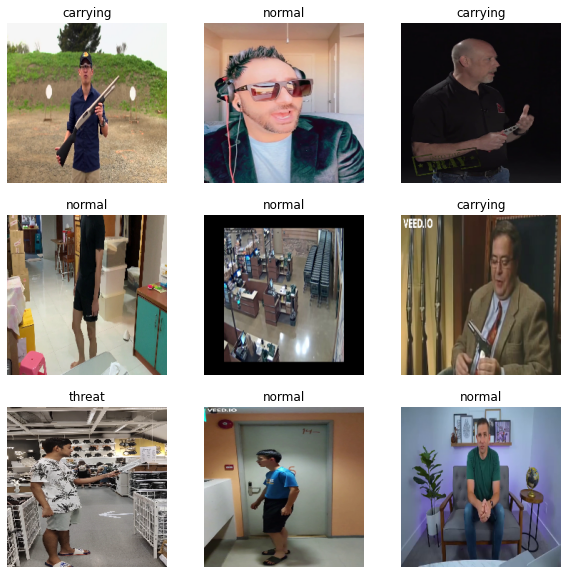

In [18]:
train_ds_iter = iter(train_ds)
plt.figure(figsize=(10, 10))
for i in range(9):
    image, label = next(train_ds_iter)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    label = label
    plt.title(class_names[label])
    plt.axis("off")

In [19]:
# Pre-trained ResNetV2 weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
normalize = layers.Rescaling(scale=1 / 127.5, offset=-1)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, batch_size=32, rescale=True, shuffle=False, augment=False, seed=123):
  # Resize and rescale all datasets.
  if rescale:
    ds = ds.map(lambda x, y: (normalize(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000, seed=seed)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [20]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [21]:
image_height, image_width = image_size
print(image_height, image_width)

224 224


In [22]:
base_model = keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [23]:
num_classes = len(class_names)

In [24]:
base_model.trainable = False
inputs = keras.Input(shape=(image_height, image_width, 3))
x = base_model(inputs, training=False)
x = layers.Dense(120, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(84, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 84)                10164     
                                                                 
 dropout_1 (Dropout)         (None, 84)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 255   

In [25]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=5,
                                     restore_best_weights=True)
]

In [26]:
# Prepare model for transfer learning
tl_optimizer = tf.keras.optimizers.Adam()
tl_loss = tf.keras.losses.SparseCategoricalCrossentropy()
tl_metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
model.compile(tl_optimizer, tl_loss, tl_metrics)

In [27]:
# We are going to do transfer learning for 10 epochs
tl_epochs = 10

In [28]:
# Transfer learning
tl_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=tl_epochs,
    callbacks=callbacks
)

Epoch 1/10
99/99 [==============================] - 712s 6s/step - loss: 0.9084 - accuracy: 0.5789 - val_loss: 0.7715 - val_accuracy: 0.6894
Epoch 2/10
99/99 [==============================] - 144s 1s/step - loss: 0.6853 - accuracy: 0.6976 - val_loss: 0.7221 - val_accuracy: 0.7323
Epoch 3/10
99/99 [==============================] - 149s 1s/step - loss: 0.5780 - accuracy: 0.7614 - val_loss: 0.6441 - val_accuracy: 0.7424
Epoch 4/10
99/99 [==============================] - 154s 1s/step - loss: 0.4653 - accuracy: 0.8128 - val_loss: 0.6470 - val_accuracy: 0.7702
Epoch 5/10
99/99 [==============================] - 141s 984ms/step - loss: 0.3626 - accuracy: 0.8532 - val_loss: 0.7045 - val_accuracy: 0.7601
Epoch 6/10
99/99 [==============================] - 143s 983ms/step - loss: 0.2912 - accuracy: 0.8848 - val_loss: 0.7603 - val_accuracy: 0.7576
Epoch 7/10
99/99 [==============================] - 144s 1s/step - loss: 0.2562 - accuracy: 0.9034 - val_loss: 0.7636 - val_accuracy: 0.7601
Epoch 8

In [29]:
model.evaluate(test_ds, return_dict = True)

13/13 [==============================] - 100s 8s/step - loss: 0.6457 - accuracy: 0.7172


{'loss': 0.645680844783783, 'accuracy': 0.7171717286109924}

13/13 [==============================] - 18s 1s/step


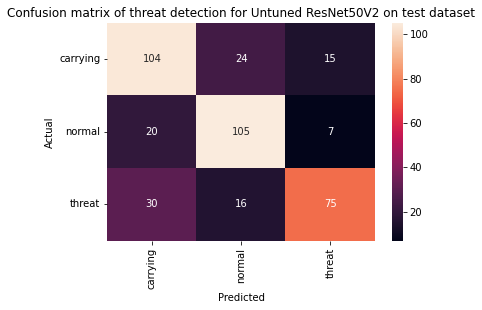

In [31]:
labels = class_names.tolist()

actual, predicted = get_actual_predicted_labels(model, test_ds)
plot_confusion_matrix(actual, predicted, labels, 'Untuned ResNet50V2 on test dataset')

In [32]:
save_model(model, 'resnet50v2-untuned')

In [33]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,2.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

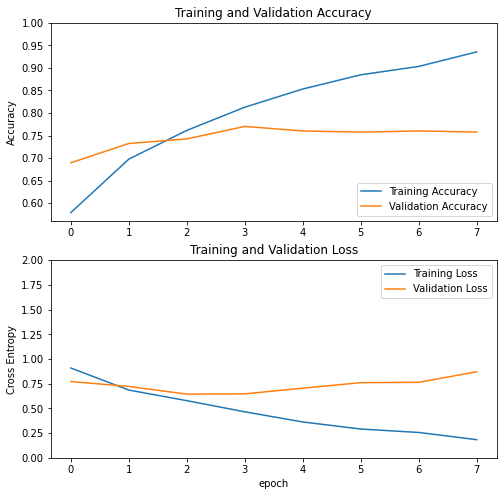

In [34]:
plot_history(tl_history)

In [35]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  191


In [36]:
# Finetune from a specific layers upward
num_layers_to_freeze = 0
for i, layer in enumerate(base_model.layers):
  if 'conv3' in layer.name:
    num_layers_to_freeze = i
    break
num_layers_to_freeze

40

In [37]:
for layer in base_model.layers[:num_layers_to_freeze]:
  layer.trainable = False

In [38]:
ft_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
ft_loss = tf.keras.losses.SparseCategoricalCrossentropy()
ft_metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

In [39]:
model.compile(ft_optimizer, ft_loss, ft_metrics)

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 84)                10164     
                                                                 
 dropout_1 (Dropout)         (None, 84)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 255   

In [41]:
ft_epochs = 10

In [42]:
# Finetuning
ft_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=ft_epochs,
    callbacks=callbacks
)

Epoch 1/10
99/99 [==============================] - 165s 1s/step - loss: 0.4252 - accuracy: 0.8321 - val_loss: 0.6106 - val_accuracy: 0.7626
Epoch 2/10
99/99 [==============================] - 143s 1s/step - loss: 0.2145 - accuracy: 0.9283 - val_loss: 0.6053 - val_accuracy: 0.7879
Epoch 3/10
99/99 [==============================] - 143s 1s/step - loss: 0.1244 - accuracy: 0.9605 - val_loss: 0.6738 - val_accuracy: 0.8005
Epoch 4/10
99/99 [==============================] - 143s 1s/step - loss: 0.0709 - accuracy: 0.9785 - val_loss: 0.7186 - val_accuracy: 0.7879
Epoch 5/10
99/99 [==============================] - 142s 1s/step - loss: 0.0415 - accuracy: 0.9861 - val_loss: 0.8737 - val_accuracy: 0.7828
Epoch 6/10
99/99 [==============================] - 142s 1s/step - loss: 0.0327 - accuracy: 0.9902 - val_loss: 0.8537 - val_accuracy: 0.7854
Epoch 7/10
99/99 [==============================] - 142s 1s/step - loss: 0.0210 - accuracy: 0.9943 - val_loss: 0.9193 - val_accuracy: 0.8005


In [43]:
model.evaluate(test_ds, return_dict = True)

13/13 [==============================] - 16s 1s/step - loss: 0.5828 - accuracy: 0.7828


{'loss': 0.5828068852424622, 'accuracy': 0.7828282713890076}

13/13 [==============================] - 16s 1s/step


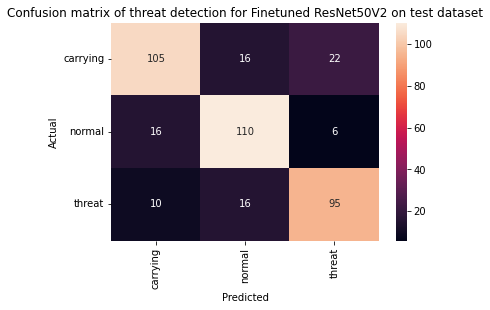

In [45]:
labels = class_names.tolist()

actual, predicted = get_actual_predicted_labels(model, test_ds)
plot_confusion_matrix(actual, predicted, labels, 'Finetuned ResNet50V2 on test dataset')

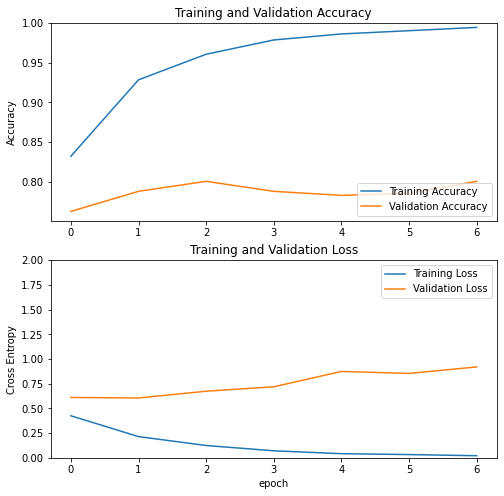

In [46]:
plot_history(ft_history)

In [47]:
save_model(model, 'resnet50v2-finetuned')